In [91]:
import pandas as pd
import numpy as np
import itertools
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from scipy.stats import loguniform
from scipy.stats import loguniform, beta, uniform
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

🌟 Introduction
Dataset used in this notebook aims to classificate stars, galaxies, and quasars based on their spectral characteristics.  The dataset is an imbalanced dataset. For this reason, Synthetic Minority Oversampling Technique (SMOTE) is used to eliminate the imbalance between classes. Outlier values are detected with the Local Outlier Factor and these values are removed from the dataset. In the 16-dimensional data set, the correlations of the features with the class label are checked and the features with a correlation greater than 0.16 are used for classification. In addition, the seaborn library and the yellow brick library are used for data visualization.

In [92]:
df = pd.read_csv(r'C:\Users\YUSUF\Downloads\star_classification.csv')
df.head()


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [93]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

First of all the labels of the data are strings. We need to map them to unique integer numbers for each class. Then as the requariment of the project I need to distrube the data and then fill the data. Afterwards as a requariment I am going to drop the columns that doesnt serve anything or doesnt contribute to a classification task. For example: id's.

In [94]:
df["class"].value_counts()


class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

The class values are very unbalanced. This situation will create problems when we train the model .I am going to overcome this situation by sampling the class STAR and QSO and increasing their value to 59445.

Maping class label to integer numbers

In [95]:
# Map the 'class' column to numerical values
df['class'] = df['class'].map({'GALAXY': 0, 'STAR': 1, 'QSO': 2})

# Verify the mapping
df['class'].head(10)

0    0
1    0
2    0
3    0
4    0
5    2
6    2
7    0
8    0
9    1
Name: class, dtype: int64

DETECTING OUTLIERS

Detecting outliers refers to identifying data points that are significantly different from the majority of the data in a dataset. Outliers can be indicative of measurement errors, experimental errors, or they may be valid observations that are simply rare or unusual. Detecting and handling outliers is crucial because they can skew statistical analyses and machine learning models, leading to incorrect conclusions or predictions.

In [96]:
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df)
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score




In [97]:
#threshold
threshold2 = -10
filtre2 = outlier_score["score"] < threshold2
outlier_index = outlier_score[filtre2].index.tolist()
len(outlier_index)

threshold2 = np.percentile(outlier_score["score"], 5)
print(f"Threshold based on 5th percentile: {threshold2}")

Threshold based on 5th percentile: -4.384498239360391


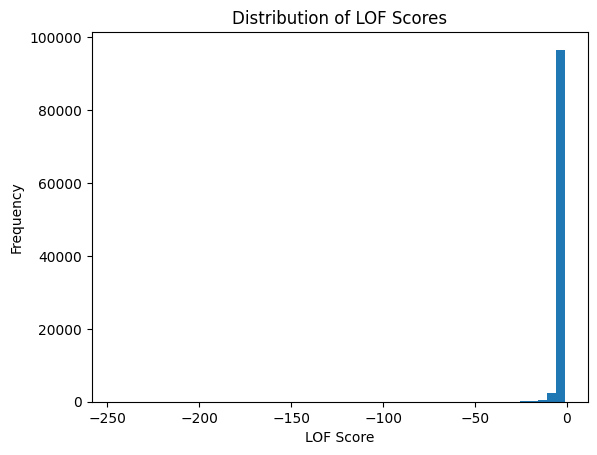

In [98]:
plt.hist(outlier_score["score"], bins=50)
plt.xlabel("LOF Score")
plt.ylabel("Frequency")
plt.title("Distribution of LOF Scores")
plt.show()

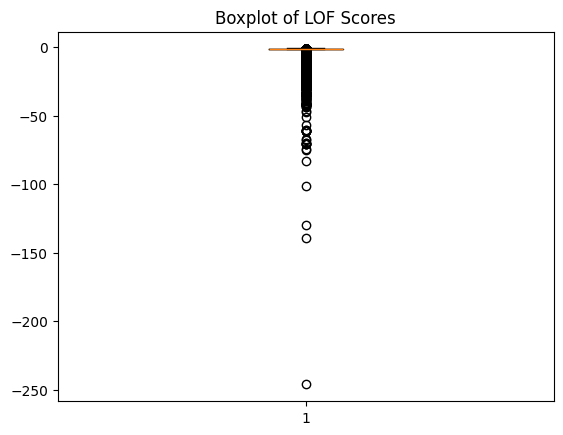

In [99]:
plt.boxplot(outlier_score["score"])
plt.title("Boxplot of LOF Scores")
plt.show()

In [100]:
#Dropping the outliers
df.drop(outlier_index, inplace=True)
df.shape

(98742, 18)

**Plotting the class imbalance**

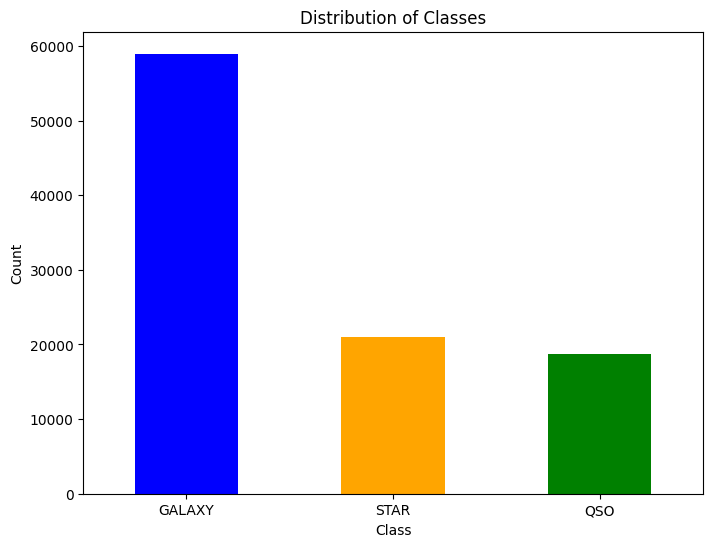

In [101]:
# Plot the distribution of classes
class_counts = df['class'].value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(ticks=[0, 1, 2], labels=['GALAXY', 'STAR', 'QSO'], rotation=0)
plt.show()

Visulazition of data integrity

<Axes: >

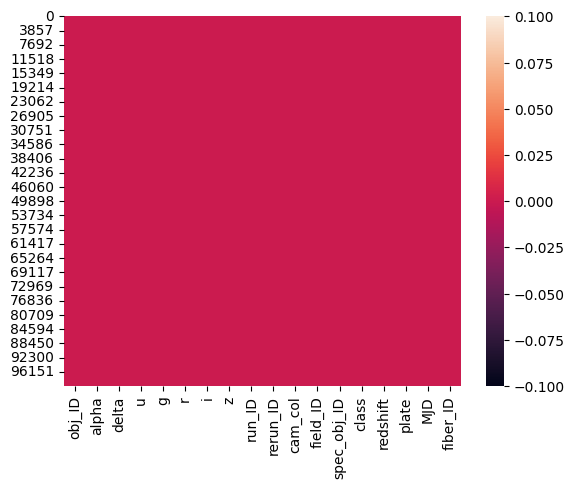

In [102]:
sns.heatmap(df.isnull())

There are No NULL values it distortion in the data. AS a requariment of the project I am going the remove some values (except class labels) randomly.

In [103]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(X.index, size=size, replace=False)

    X[indexes] = np.nan
    return X
df.columns


Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [104]:
noisy_cols = ['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i','z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'redshift','plate', 'MJD', 'fiber_ID']

amount_of_noise = 0.06


for col in noisy_cols:
    if col in df.columns:
        print(f"Processing column: {col}")
        df[col] = add_missing(df[col], amount_of_noise)
    else:
        print(f"Column {col} does not exist in the DataFrame.")

Processing column: obj_ID
Processing column: alpha
Processing column: delta
Processing column: u
Processing column: g
Processing column: r
Processing column: i
Processing column: z
Processing column: run_ID
Processing column: rerun_ID
Processing column: cam_col
Processing column: field_ID
Processing column: spec_obj_ID
Processing column: redshift
Processing column: plate
Processing column: MJD
Processing column: fiber_ID


Visualization of missing values after distortion of the dataset

<Axes: >

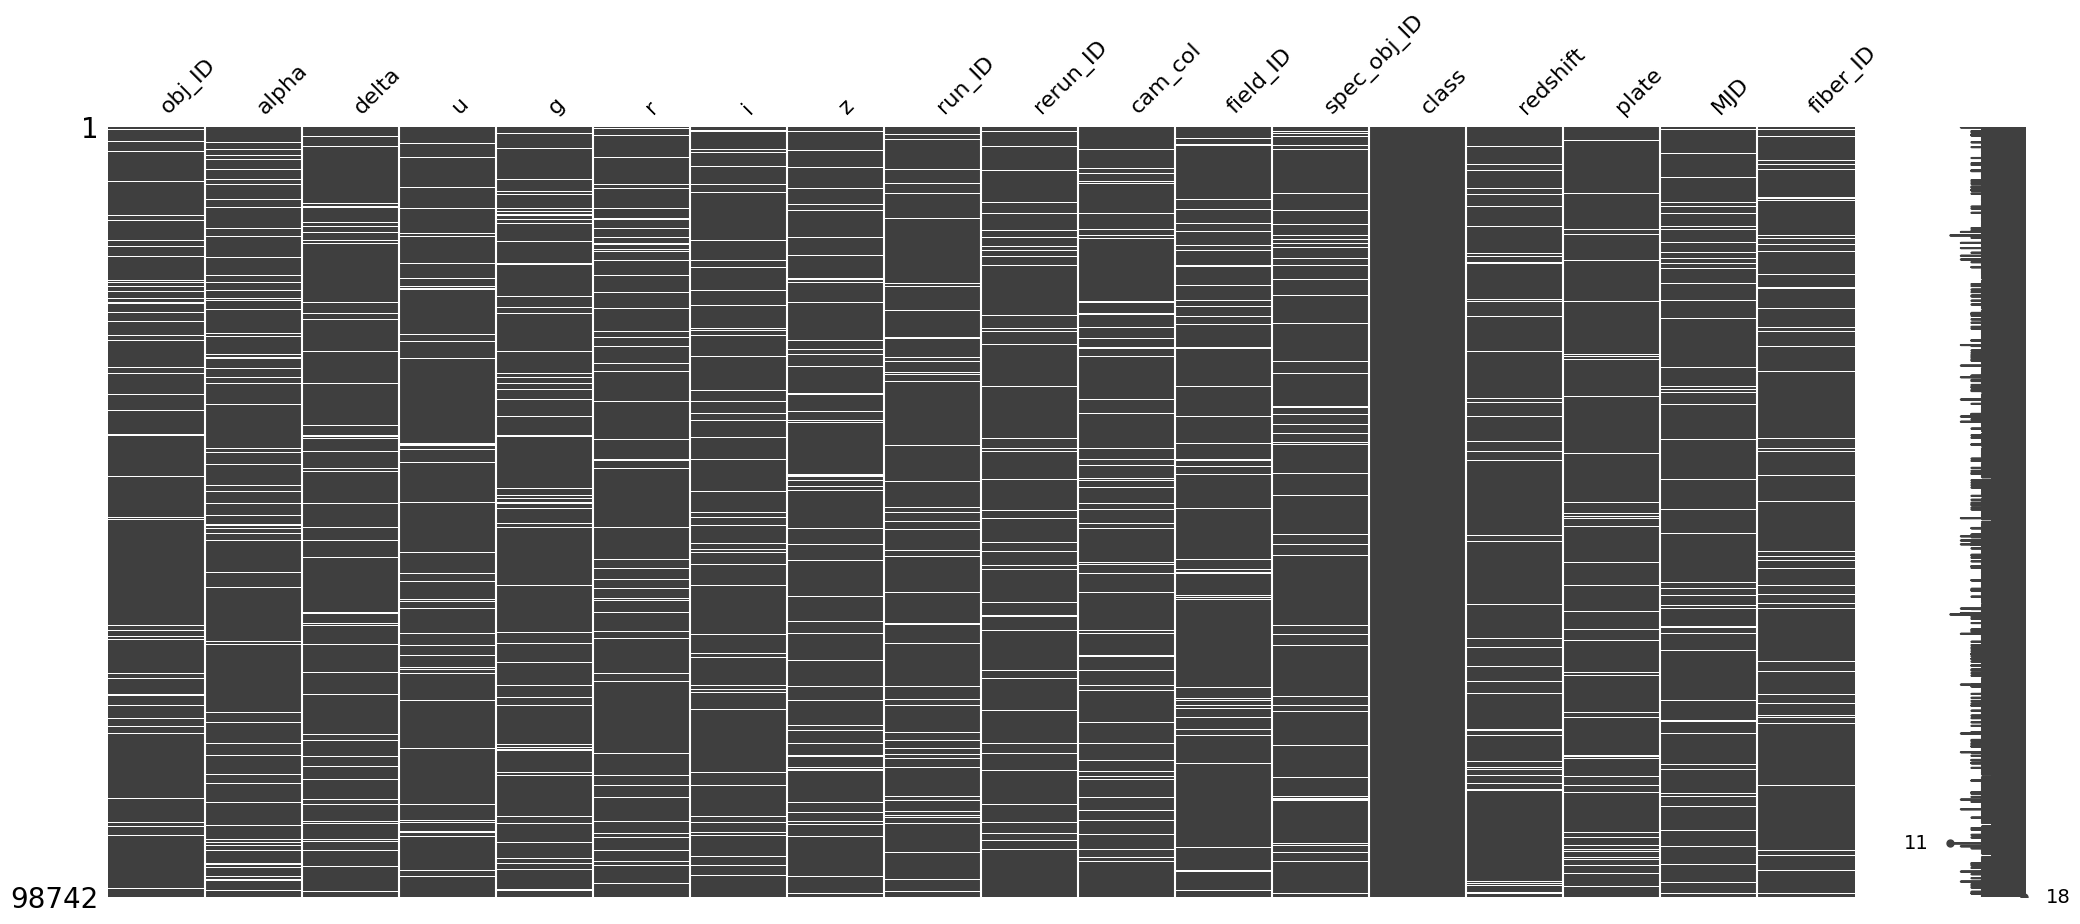

In [105]:
msno.matrix(df)

In [106]:
# pipeline_age_fare = Pipeline([
#     ('imp', KNNImputer(n_neighbors=5) ),
#     ('scaler', StandardScaler() )
# ])
# samlpe imputing pipeline for further usage


In [107]:
df.isnull().sum()


obj_ID         5924
alpha          5924
delta          5924
u              5924
g              5924
r              5924
i              5924
z              5924
run_ID         5924
rerun_ID       5924
cam_col        5924
field_ID       5924
spec_obj_ID    5924
class             0
redshift       5924
plate          5924
MJD            5924
fiber_ID       5924
dtype: int64

Sofisticated method :Training a model to predict the missing values. Separeting the values as missing and non missing. Training with non missing values and predicting the missing values.

Visualizing

Simpler method: identifying individual needs of the columns. And applying different techiques to fill the values

	1.	Continuous numerical columns (u, g, r, i, z, redshift):
	•	Mean/Median Imputation: If the data is normally distributed, filling missing values with the mean can be a good option. If the data is skewed, the median might be more appropriate.
    2.	Identifier columns (spec_obj_ID, plate, MJD):
	•	Mode Imputation: Since these columns are likely categorical identifiers, filling missing values with the most frequent value (mode) can be a simple and effective approach.
    1.	Fill continuous numerical columns using mean or median imputation.
	2.	Fill identifier columns using mode imputation.

FEATURE SELECTION

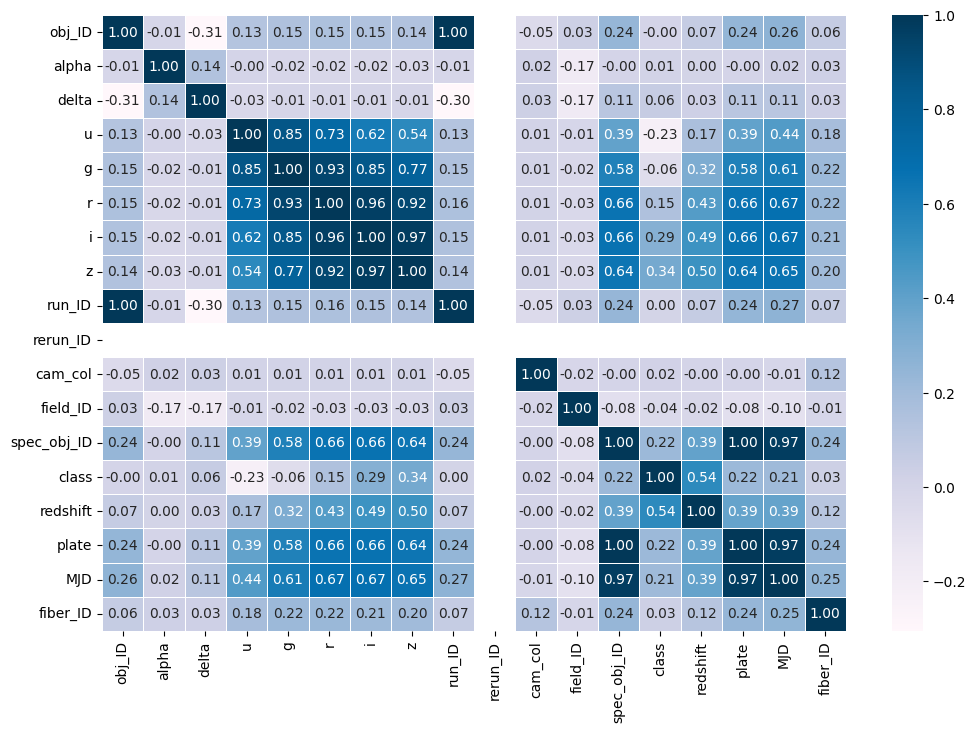

In [108]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

In [109]:

# Calculate the correlation matrix
corr_matrix = df.corr()

# For each column, get the top 3 most correlated columns
top_correlations = {}
for column in corr_matrix.columns:
    top_correlations[column] = corr_matrix[column].sort_values(ascending=False).iloc[1:4]

# Convert the dictionary to a DataFrame for better readability
top_correlations_df = pd.DataFrame(top_correlations)

# Print the top correlations for each column
print("Top Correlations for Each Column:\n", top_correlations_df)

Top Correlations for Each Column:
                obj_ID     alpha     delta         u         g         r  \
MJD          0.264651  0.021619       NaN       NaN       NaN       NaN   
alpha             NaN       NaN  0.138381       NaN       NaN       NaN   
class             NaN       NaN       NaN       NaN       NaN       NaN   
delta             NaN  0.138381       NaN       NaN       NaN       NaN   
fiber_ID          NaN  0.028657       NaN       NaN       NaN       NaN   
g                 NaN       NaN       NaN  0.852520       NaN  0.932202   
i                 NaN       NaN       NaN  0.615768  0.846622  0.962868   
obj_ID            NaN       NaN       NaN       NaN       NaN       NaN   
plate        0.241159       NaN  0.112511       NaN       NaN       NaN   
r                 NaN       NaN       NaN  0.726536  0.932202       NaN   
redshift          NaN       NaN       NaN       NaN       NaN       NaN   
run_ID       1.000000       NaN       NaN       NaN       NaN    

fiber_ID: This column has low correlations with most other features, so it might not contribute much useful information.
obj_ID and run_ID: Both have a correlation of 1.0 with each other and -0.30 with delta. High correlation between these two suggests redundancy.
rerun_ID: This column seems to have almost no correlation with other features, indicated by the dashes, suggesting it may not provide useful information.

In [110]:
df = df.drop(columns=['rerun_ID', 'obj_ID', 'run_ID', 'fiber_ID'])

# Display the first few rows to verify the columns have been dropped
print(df.head())

        alpha      delta         u         g         r         i         z  \
0         NaN  32.494632       NaN  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656       NaN  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   cam_col  field_ID   spec_obj_ID  class  redshift    plate      MJD  
0      2.0      79.0  6.543777e+18      0       NaN   5812.0  56354.0  
1      5.0     119.0  1.176014e+19      0  0.779136  10445.0  58158.0  
2      2.0     120.0  5.152200e+18      0  0.644195   4576.0  55592.0  
3      3.0     214.0  1.030107e+19      0  0.932346   9149.0  58039.0  
4      3.0     137.0  6.891865e+18      0  0.116123   6121.0  56187.0  


	1.	Strong Positive Correlations:
	•	u and g : These features have a strong positive correlation, indicating that as one increases, the other tends to increase as well.
	•	u and r  u and i, u and z : Similar strong positive correlations are seen between u and these other features, suggesting they likely measure related characteristics.
	•	g, r, i, and z also show strong inter-correlations , indicating these features are related and probably represent different bands of photometric data.
	2.	Moderate Correlations:
	•	class shows moderate positive correlation with redshift, suggesting that the classification may have some relationship with the redshift.
	3.	Weak/Negative Correlations:
	•	u shows a weak negative correlation with spec_obj_ID (-0.22), which is not very significant but may indicate that spec_obj_ID doesn’t follow the same pattern as other numerical features.

COMMENTS;
since u, g, r, i, z show correlation we can merge them to one feature without losing some information. Thus we can run the algotihm efficiently. But since high correlation creates overfitting we can use PCA technique to improve the performance.
   

In [111]:
corr = df.corr()
corr["class"].sort_values()

u             -0.225499
g             -0.063930
field_ID      -0.036900
alpha          0.006704
cam_col        0.015357
delta          0.057418
r              0.152849
MJD            0.208026
spec_obj_ID    0.217899
plate          0.218402
i              0.288383
z              0.342822
redshift       0.539122
class          1.000000
Name: class, dtype: float64

Showing the top correlation values for each feature

Train Test Split

In [112]:
X = df.drop(columns=['class'])
y = df['class']


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

Creating a pipeline for the model

	Imputation Before Splitting:
  Suppose your entire dataset has a column with missing values. If you compute the mean (say, 50) across the entire dataset and fill in the missing values with this mean, you’ve used information from the test set to compute the mean. This is problematic because the mean you’re using is not just based on the data available at training time; it’s influenced by the test data as well. This makes your model prone to overfitting and leads to misevaluation on test data that can create a bad performance in real life while it was good on test data
  

FILLING MISSING VALUES SEPERATELLY FOR TRAINING AND TESTING SETS

In [114]:

# Assuming X_train and y_train are both pandas DataFrames or Series
train_data = pd.concat([X_train, y_train], axis=1)

In [115]:
def impute_missing_values(df, target_column):
    # Split the data into two parts: one with missing values and one without
    df_missing = df[df[target_column].isna()]
    df_no_missing = df[df[target_column].notna()]

    # Separate features and target
    X_train = df_no_missing.drop(columns=[target_column])
    y_train = df_no_missing[target_column]

    X_missing = df_missing.drop(columns=[target_column])

    # Create a pipeline with an imputer and the model
    model = make_pipeline(SimpleImputer(strategy='mean'), HistGradientBoostingRegressor())

    # Train the model
    model.fit(X_train, y_train)

    # Predict the missing values
    y_pred = model.predict(X_missing)

    # Fill in the missing values
    df.loc[df[target_column].isna(), target_column] = y_pred

    return df



In [116]:
# List of columns with missing values
columns_with_missing_values = [col for col in X_train.columns if df[col].isna().sum() > 0]

# Impute missing values for each column
for column in columns_with_missing_values:
    train_data = impute_missing_values(train_data, column)

# Verify that there are no missing values
print(train_data.isna().sum())

alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
cam_col        0
field_ID       0
spec_obj_ID    0
redshift       0
plate          0
MJD            0
class          0
dtype: int64


Separating them again after filling the missing values

In [117]:
X_train = train_data.drop(columns=['class'])
y_train = train_data['class']

In [118]:
test_data = pd.concat([X_test, y_test], axis=1)

In [119]:
# Impute missing values for each column
columns_with_missing_values = [col for col in X_test.columns if df[col].isna().sum() > 0]

for column in columns_with_missing_values:
    test_data = impute_missing_values(test_data, column)

# Verify that there are no missing values
print(test_data.isna().sum())

alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
cam_col        0
field_ID       0
spec_obj_ID    0
redshift       0
plate          0
MJD            0
class          0
dtype: int64


Separating them again after filling the missing values

In [120]:
X_test= test_data.drop(columns=['class'])
y_test = test_data['class']

In [121]:
#since i already transformed the class column to numerical values, I am not going to use the onehotencoder
model_pipeline = IMBPipeline([
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

In [122]:
# Fill missing values for continuous numerical columns with median
# numerical_columns = ['u', 'g', 'r', 'i', 'z', 'redshift']
# for column in numerical_columns:
#     df[column].fillna(df[column].median(), inplace=True)

# # Fill missing values for identifier columns with mode
# identifier_columns = ['spec_obj_ID', 'plate', 'MJD']
# for column in identifier_columns:
#     df[column].fillna(df[column].mode()[0], inplace=True)

# # Check if there are any missing values left
# df.isnull().sum()

IMPLEMENTATION WITH PIPELINE

In [123]:
# Identify numerical and categorical columns
# numerical_columns = ['u', 'g', 'r', 'i', 'z', 'redshift']
# identifier_columns = ['spec_obj_ID', 'plate', 'MJD']

# # Create an imputer for numerical columns (median imputation)
# numerical_imputer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median'))
# ])

# # Create an imputer for identifier columns (mode imputation)
# identifier_imputer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent'))
# ])

# # Combine both imputers into a column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_imputer, numerical_columns),
#         ('id', identifier_imputer, identifier_columns)
#     ]
# )

# # Apply the transformations to the dataframe
# df[numerical_columns + identifier_columns] = preprocessor.fit_transform(df)

# # Verify that there are no missing values left
# missing_values_after = df.isnull().sum()
# print("Missing values after imputation:\n", missing_values_after)

Chosing model by trying all the possible combinations with different type of dimention reduction, classifier and sampling techniques

	1.	Logistic Regression:
	•	Advantages: Simple, interpretable, fast, works well with linear relationships.
	•	Disadvantages: May not perform well with complex or non-linear relationships.
	2.	Decision Trees:
	•	Advantages: Easy to interpret, handles non-linear relationships, works well with mixed data types.
	•	Disadvantages: Prone to overfitting, especially with deep trees.
	3.	Random Forest:
	•	Advantages: Reduces overfitting by averaging multiple trees, handles non-linear relationships, robust to noise.
	•	Disadvantages: Less interpretable, can be computationally expensive with large datasets.
	4.	Gradient Boosting Machines (GBM):
	•	Advantages: High predictive accuracy, handles non-linear relationships, can work well with a variety of data types.
	•	Disadvantages: Can be slow to train, sensitive to hyperparameters.
	5.	Support Vector Machines (SVM):
	•	Advantages: Effective in high-dimensional spaces, robust to overfitting in high-dimensional space.
	•	Disadvantages: Computationally intensive, less effective with large datasets, requires careful tuning of hyperparameters.
	6.	Neural Networks:
	•	Advantages: Highly flexible, capable of modeling complex patterns, state-of-the-art performance in many tasks.
	•	Disadvantages: Requires large amounts of data, computationally expensive, less interpretable.
	7.	K-Nearest Neighbors (KNN):
	•	Advantages: Simple, no training phase, effective with small datasets.
	•	Disadvantages: Computationally expensive during prediction, sensitive to irrelevant features and the scale of data.

In [124]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(multi_class='ovr', solver='saga')], # One-vs-Rest (OVR) Strategy
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    },
    {
        'classifier': [HistGradientBoostingClassifier()],
        'classifier__learning_rate': loguniform(0.01, 0.2),
        'classifier__max_iter': [100, 200, 300],
        'classifier__max_depth': [None, 3, 5, 7],
    },

]

In [125]:
#LESS COMPACT WAY
# all_configs = [dict(itertools.chain(*(e.items()
# for e in configuration)))
# for configuration in
# itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

all_configs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [126]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 60'

In [127]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1_weighted'
)

In [128]:
scores = cross_validate(rs, X_train, y_train, scoring='f1_weighted',  cv = 3, return_estimator=True, verbose=3) # choosing f1_weighted metric because it is a multiclass classification problem

[CV] END ......................................., score=0.976 total time= 1.6min
[CV] END ......................................., score=0.976 total time= 1.4min
[CV] END ......................................., score=0.976 total time= 1.0min


In [129]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
HistGradientBoostingClassifier(learning_rate=np.float64(0.11064004406537628)) {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': np.float64(0.11064004406537628), 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.9763118537490256
----------
None
None
HistGradientBoostingClassifier(learning_rate=np.float64(0.023830209660537012),
                               max_depth=7, max_iter=300) {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': np.float64(0.023830209660537012), 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 7, 'max_feature

As we can understand here the best out of the others is RandomForestClassifier without any sampling or dimensional reduction need

In [130]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train,average='weighted' )
    f1_test = f1_score(y_test, pred_test,average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9871928364169392, F1 on test set:0.9771580258801279
F1 on training set:0.9831311645824569, F1 on test set:0.9776985512156832
F1 on training set:0.9833355811752174, F1 on test set:0.9772084875222529


hyperparameter optmization

In [131]:
sampler_configs = [
    {'sampler': [None]},
]

dim_reduction_configs = [
    {'dim_reduction': [None]},
]


classifier_configs = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__bootstrap': [True],
        'classifier__ccp_alpha': [0.0],
        'classifier__class_weight': [None],
        'classifier__criterion': ['gini'],
        'classifier__max_depth': [None],
        'classifier__max_features': ['sqrt'],
        'classifier__max_leaf_nodes': [None],
        'classifier__max_samples': [None],
        'classifier__min_impurity_decrease': [0.0],
        'classifier__min_samples_leaf': [1],
        'classifier__min_samples_split': [2],
        'classifier__min_weight_fraction_leaf': [0.0],
        'classifier__n_estimators': [500],
        'classifier__n_jobs': [None],
        'classifier__oob_score': [False],
        'classifier__random_state': [None],
        'classifier__verbose':[0],
        'classifier__warm_start': [False]
    }
]

In [132]:

all_configs_best = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters_best = []
    for element in configuration:
        for item in element.items():
            all_parameters_best.append(item)
    all_configs_best.append(dict(all_parameters_best))

In [133]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

best_pip = IMBPipeline([
    ('sampler', SMOTE()),
    ('dim_reduction', PCA()),
    ('classifier', RandomForestClassifier())
])
gs = GridSearchCV(
        best_pip,
        param_grid=all_configs_best,
        n_jobs=-1,
        cv=5,
        scoring='f1_weighted'
    )

    # Perform the cross-validation inside the block as well
scores_gs = cross_validate(
        gs,
        X_train,
        y_train,
        scoring='f1_weighted',
        cv=5,
        return_estimator=True,
        verbose=3
    )

[CV] END ......................................., score=0.977 total time= 3.5min
[CV] END ......................................., score=0.980 total time= 3.4min
[CV] END ......................................., score=0.976 total time= 3.5min
[CV] END ......................................., score=0.978 total time= 3.5min
[CV] END ......................................., score=0.976 total time= 3.5min


Working on the best model with different parameters to see exactly which parameter fits better.

In [134]:
for index, estimator in enumerate(scores_gs['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'], estimator.best_estimator_.get_params()['classifier'].get_params())
    if index < len(scores['test_score']):
        print(scores['test_score'][index])
    else:
        print("No test score available for this index")
    print('-'*10)

None
None
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9763118537490256
----------
None
None
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9757989284735213
----------
None
N

In [135]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
HistGradientBoostingClassifier(learning_rate=np.float64(0.11064004406537628)) {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': np.float64(0.11064004406537628), 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.9763118537490256
----------
None
None
HistGradientBoostingClassifier(learning_rate=np.float64(0.023830209660537012),
                               max_depth=7, max_iter=300) {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': np.float64(0.023830209660537012), 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 7, 'max_feature

Confusion Matrixes

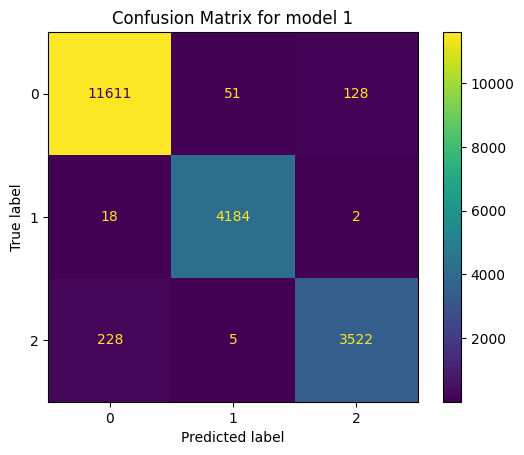

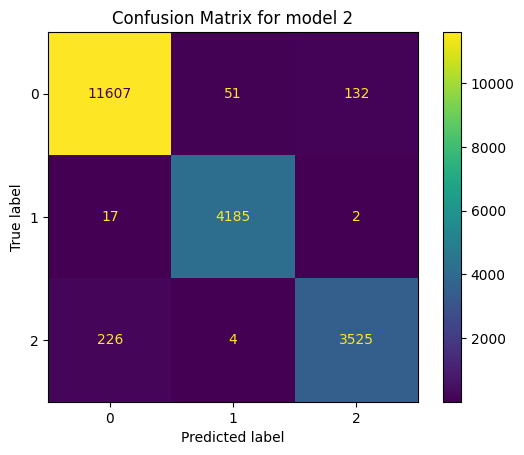

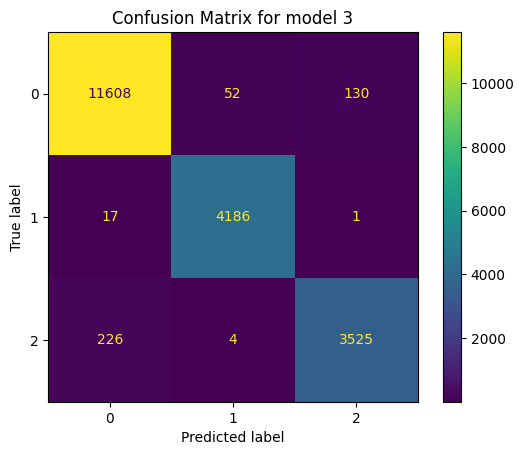

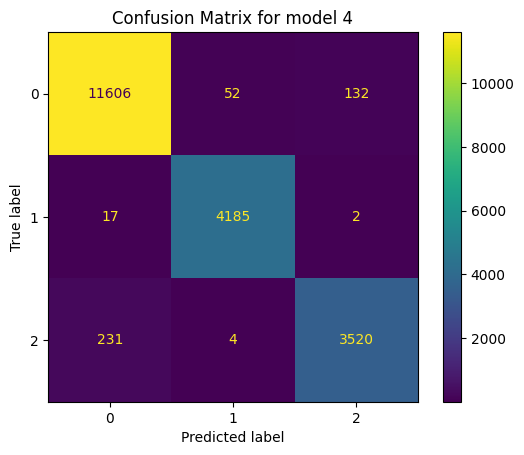

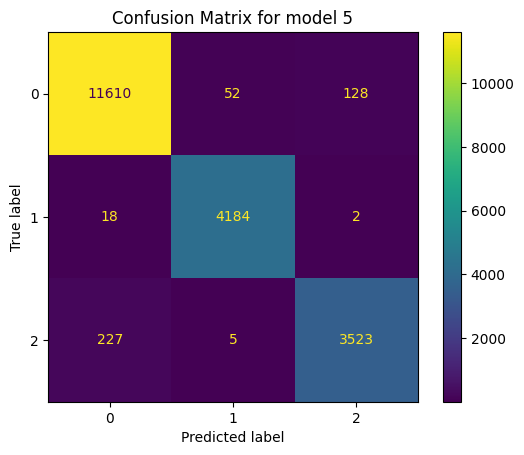

In [136]:
for index, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for model {index+1}')
    plt.show()

Model 1 shows high accuracy and generally performs well, especially for Class 0 and Class 1. However, there are some misclassifications in Class 2, where instances are sometimes predicted as Class 0. The confusion matrixes for the best performing models are the nearly the same.

I am creating Precision-Recall Curves for models to gather more information about them and decide which model performs better.

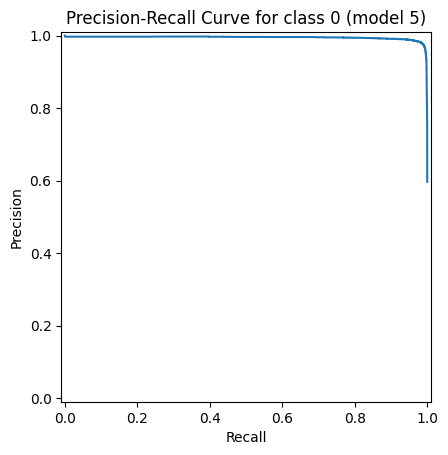

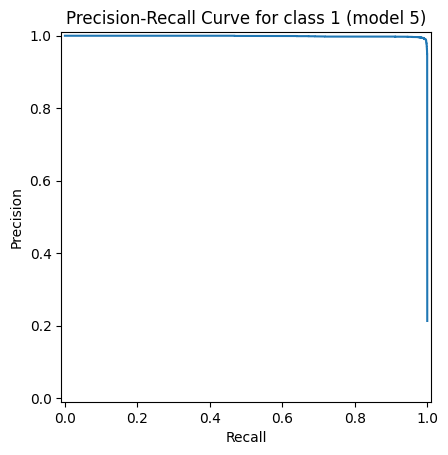

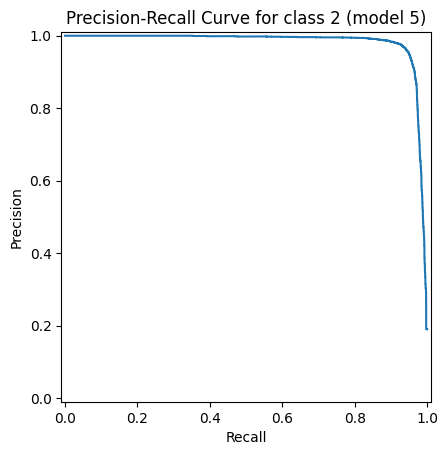

In [137]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

ovr_classifier = OneVsRestClassifier(best_model)
ovr_classifier.fit(X_train, y_train)
pred_probs = ovr_classifier.predict_proba(X_test)

for class_index in range(len(np.unique(y_test))):
    precision, recall, _ = precision_recall_curve(y_test == class_index, pred_probs[:, class_index])
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for class {class_index} (model {index+1})')
    plt.show()

Deciding the best model by evaluating the metrics. In this case it is the fourth model (3rd index)

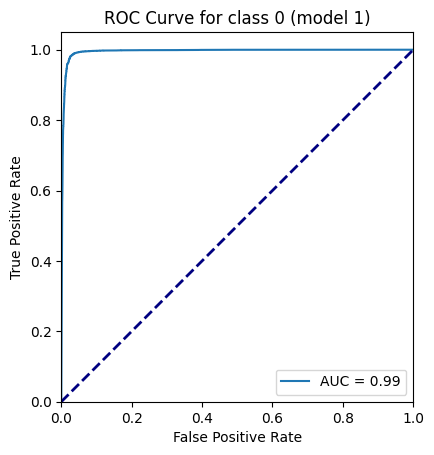

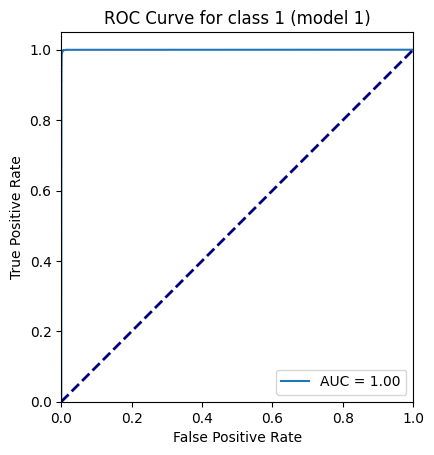

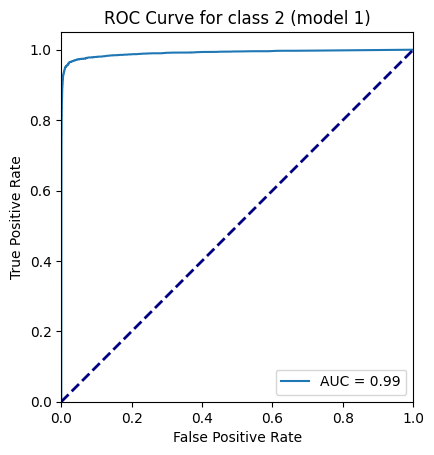

The AUC for model 1 for class 2 is: 0.99


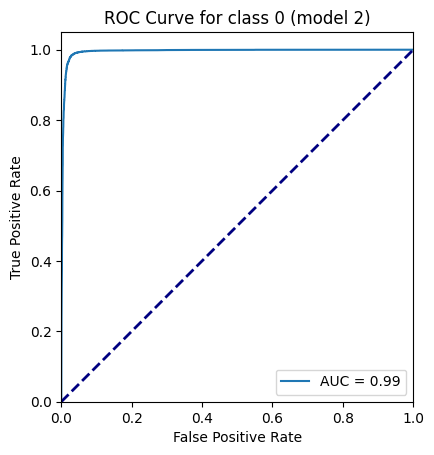

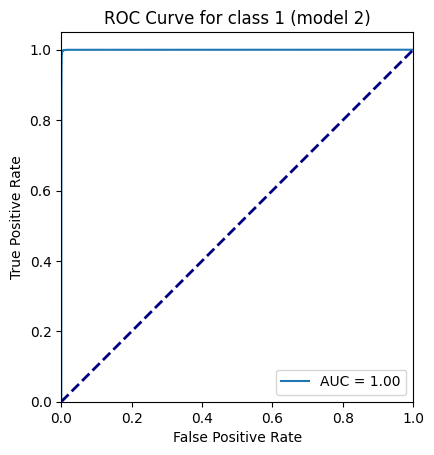

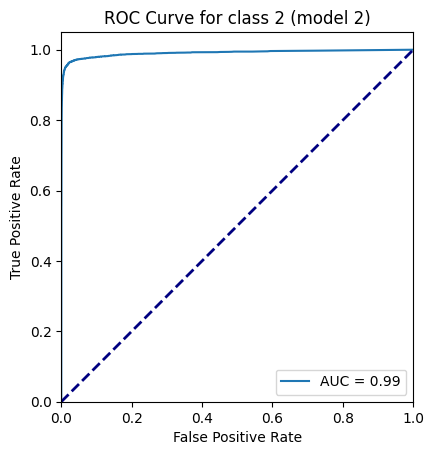

The AUC for model 2 for class 2 is: 0.99


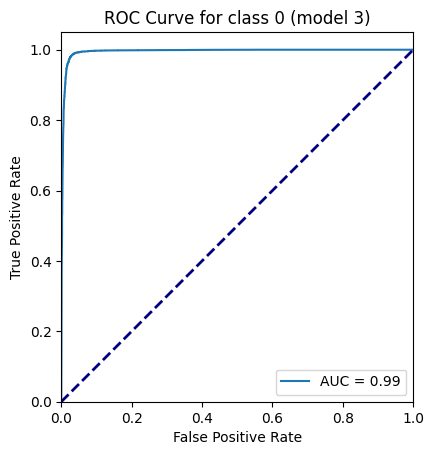

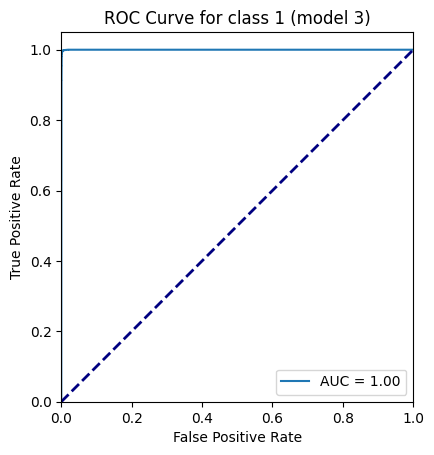

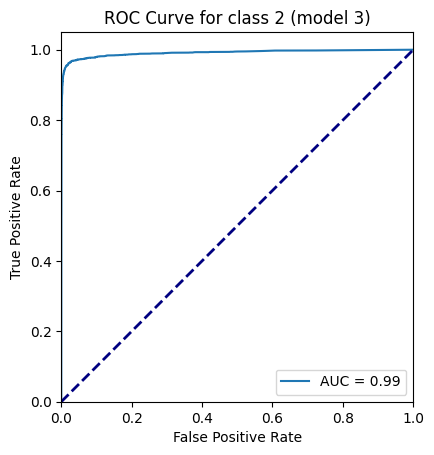

The AUC for model 3 for class 2 is: 0.99


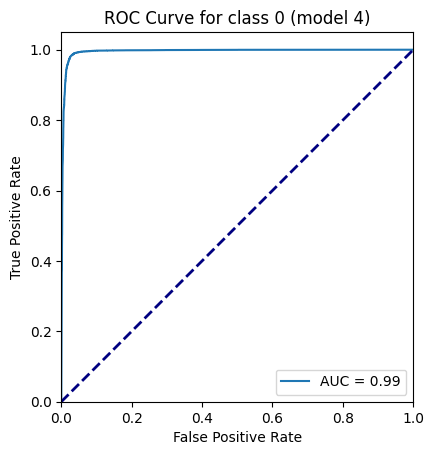

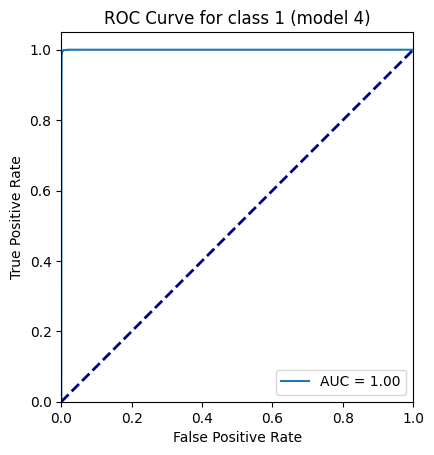

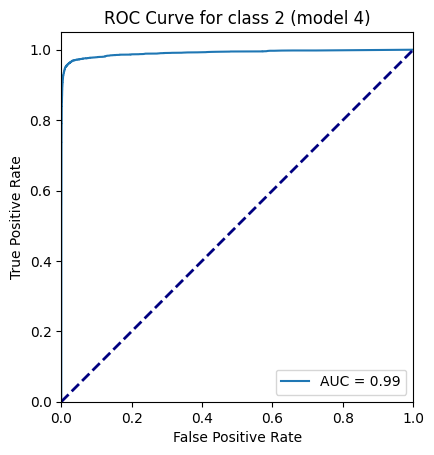

The AUC for model 4 for class 2 is: 0.99


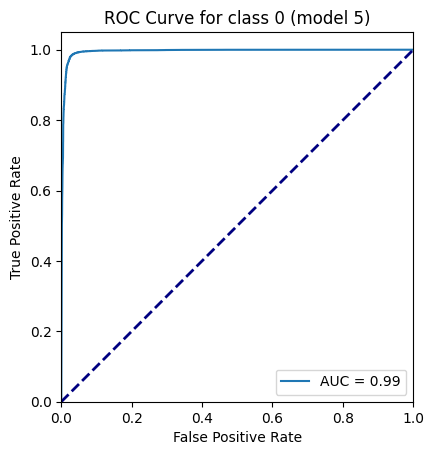

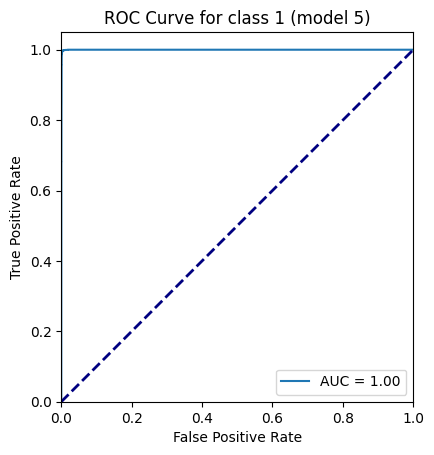

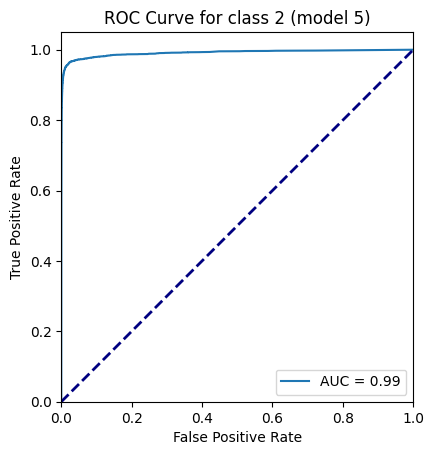

The AUC for model 5 for class 2 is: 0.99


In [138]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

for index, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    ovr_classifier = OneVsRestClassifier(best_model)
    ovr_classifier.fit(X_train, y_train)  # Fit the model on training data
    pred_probs = ovr_classifier.predict_proba(X_test)  # Predict probabilities

    for class_index in range(len(np.unique(y_test))):
        fpr, tpr, thresholds = roc_curve(y_test == class_index, pred_probs[:, class_index])
        roc_auc = auc(fpr, tpr)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for class {class_index} (model {index+1})')
        plt.legend(loc="lower right")
        plt.show()

    print(f"The AUC for model {index+1} for class {class_index} is: {roc_auc:.2f}")


In [139]:
best_model = scores_gs['estimator'][3].best_estimator_


In [140]:
best_model['classifier'].get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Learning and Validation curve


In [141]:
train_sizes, train_scores, test_scores = learning_curve(best_model,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1_weighted',
                                                       shuffle = True)

(0.6, 1.03)

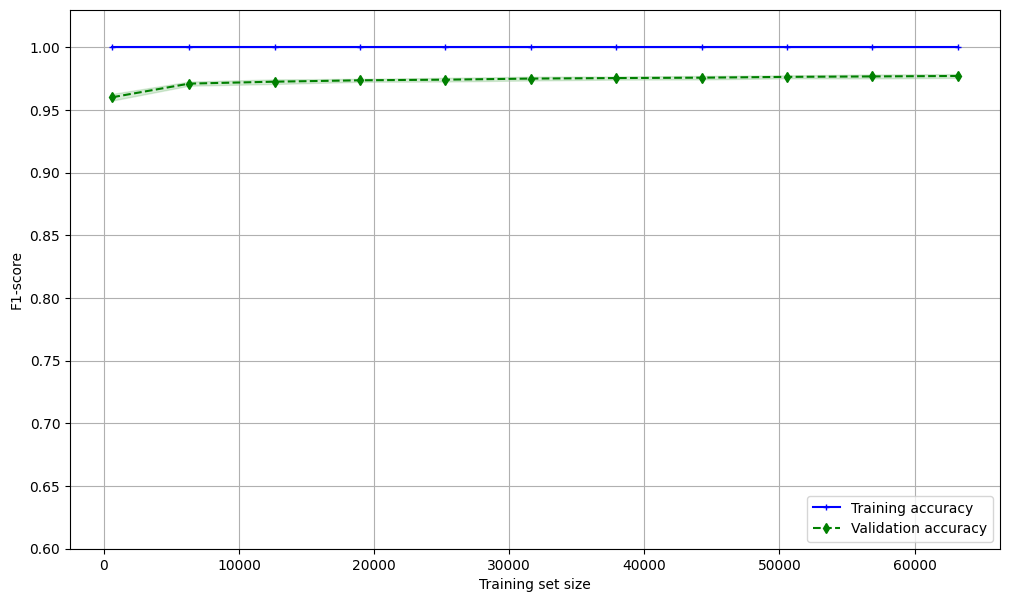

In [142]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

INSIGHTS:

Validation Accuracy: The green dashed line representing validation accuracy also shows high performance, though it is slightly lower than the training accuracy. This indicates that the model generalizes well to unseen data, but there is a slight drop compared to the training accuracy.

Stable Performance: Both training and validation accuracy lines are relatively flat and stable across the epochs. This stability indicates that the model has converged and is not suffering from significant overfitting or underfitting.

BUT

Possible Overfitting: While the validation accuracy is high, the near-perfect training accuracy could be a sign of slight overfitting. The model might have learned the training data very well, including noise, leading to nearly perfect scores on the training set.